## Log

In [4]:
!pip install transformers -q
!pip install sentencepiece -q
!pip install datasets -q
!pip install accelerate -U -q

## Basic EDA to see how long the texts are and what the prompts are

It looks like there are only 4 different prompts

In [5]:
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")

from datasets import Dataset, disable_progress_bar
import pandas as pd

pdf = pd.read_csv("./input/prompts_train.csv")
sdf = pd.read_csv("./input/summaries_train.csv")
df = pdf.merge(sdf, on="prompt_id")
df.head()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/root/miniconda3/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large")
## use the pretrained model
# from transformers import AutoConfig
# config = AutoConfig.from_pretrained('./input/pretrain/pretrained_model/')
# model = AutoModelForSequenceClassification.from_pretrained('./input/pretrain/pretrained_model', config = config)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.weight', 'classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def tokenize(example, add_prompt_question, add_prompt_text):
    """
    To see how long it would be with prompt question, prompt text, and text.
    """

    cols = []

    if add_prompt_question:
        cols.append("prompt_question")
    if add_prompt_text:
        cols.append("prompt_text")

    cols.append("text")

    return tok(
        " ".join([example[c] for c in cols]),
        padding=False,
        truncation=False
    )

In [13]:
from functools import partial

disable_progress_bar()

ds = Dataset.from_pandas(df)

tds1 = ds.map(tokenize, batched=False, num_proc=4, fn_kwargs={"add_prompt_question": True, "add_prompt_text": True})
tds2 = ds.map(tokenize, batched=False, num_proc=4, fn_kwargs={"add_prompt_question": True, "add_prompt_text": False})
tds3 = ds.map(tokenize, batched=False, num_proc=4, fn_kwargs={"add_prompt_question": False, "add_prompt_text": False})

## Lengths using prompt question, prompt text, and text

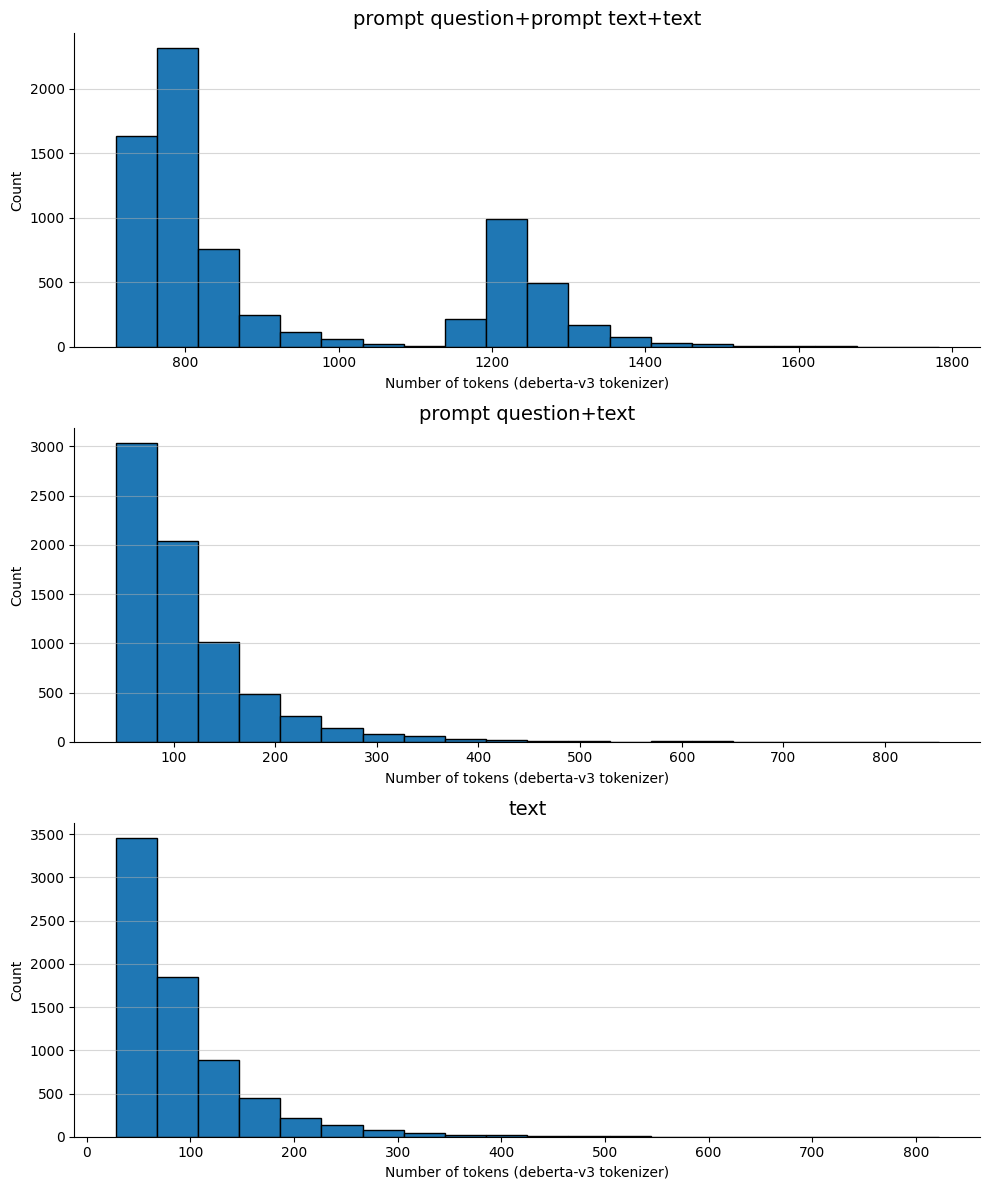

In [14]:
import matplotlib.pyplot as plt
import numpy as np

lens1 = [len(x) for x in tds1["input_ids"]]
lens2 = [len(x) for x in tds2["input_ids"]]
lens3 = [len(x) for x in tds3["input_ids"]]


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

axes[0].hist(lens1, bins=20, edgecolor='black')
axes[1].hist(lens2, bins=20, edgecolor='black')
axes[2].hist(lens3, bins=20, edgecolor='black')


titles = ['prompt question+prompt text+text', 'prompt question+text', 'text']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Number of tokens (deberta-v3 tokenizer)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(axis='y', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Distribution of content and wording labels

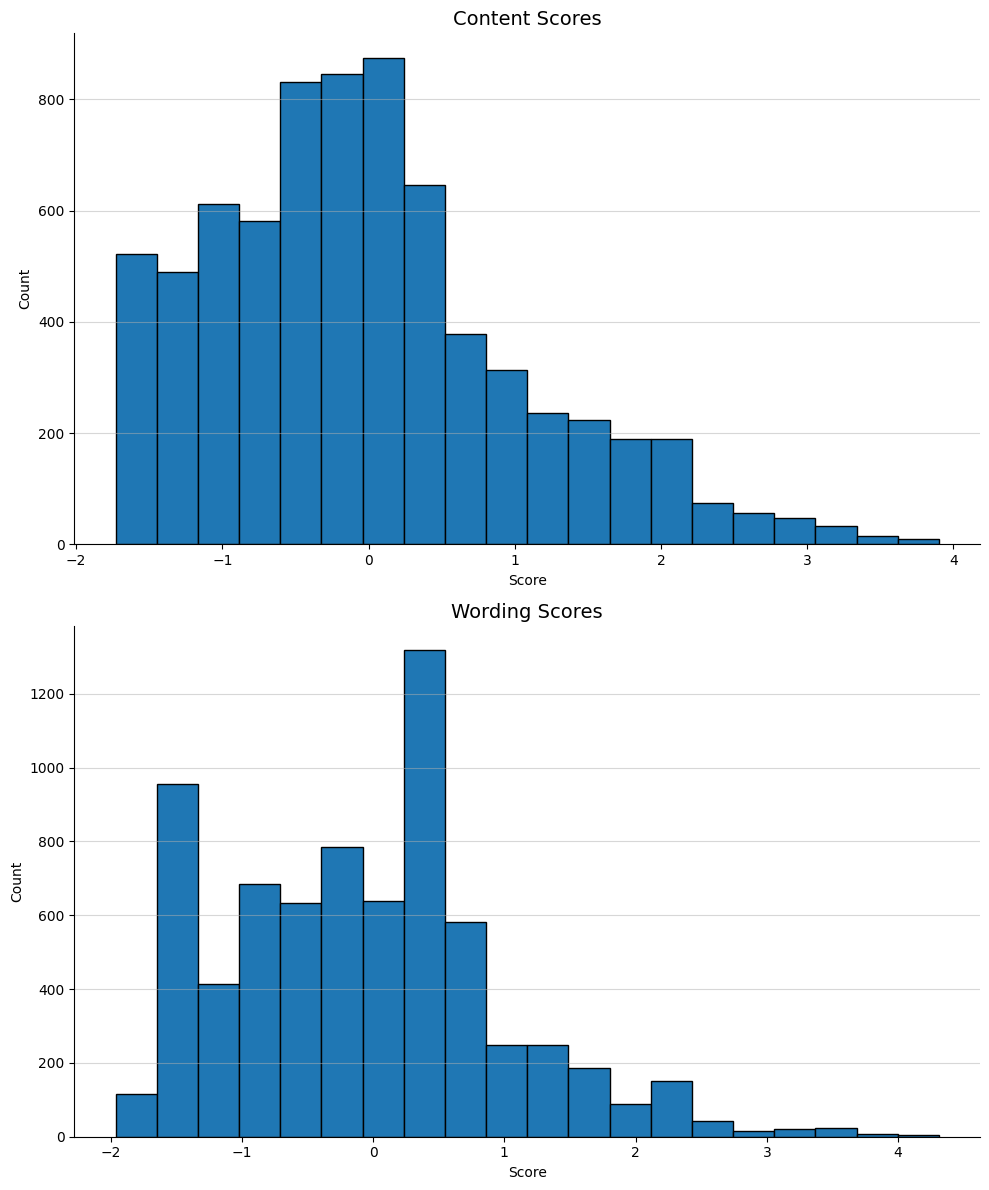

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

axes[0].hist(sdf.content, bins=20, edgecolor='black')
axes[1].hist(sdf.wording, bins=20, edgecolor='black')


titles = ['Content Scores', 'Wording Scores']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Score', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(axis='y', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [18]:
%%writefile train.py

import os
import logging
import warnings
from dataclasses import dataclass, field
from typing import Optional

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    set_seed,
    Trainer,
    TrainingArguments,
    HfArgumentParser,
    DataCollatorWithPadding,
)
from datasets import Dataset, disable_progress_bar
import pandas as pd
import numpy as np

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['WANDB_PROJECT'] = 'kaggle-commonlit-eval-student-summaries-2108'

disable_progress_bar()

@dataclass
class Config:
    model_name_or_path: Optional[str] = field(
        default="microsoft/deberta-v3-base",
        metadata={"help": "Model name or path"},
    )

    data_dir: Optional[str] = field(
        default="/kaggle/input/commonlit-evaluate-student-summaries",
        metadata={"help": "Data directory"},
    )

    max_seq_length: Optional[int] = field(
        default=1600,
        metadata={"help": "Max sequence length"},
    )

    add_prompt_question: Optional[bool] = field(
        default=False,
        metadata={"help": "Add prompt question into input"},
    )

    add_prompt_text: Optional[bool] = field(
        default=False,
        metadata={"help": "Add prompt text into input"},
    )

    fold: Optional[int] = field(
        default=0,
        metadata={"help": "Fold"},
    )

    num_proc: Optional[int] = field(
        default=4,
        metadata={"help": "Number of processes"},
    )

    dropout: Optional[float] = field(
        default=0.,
        metadata={"help": "Amount of dropout to apply"},
    )
    max_position_embeddings: Optional[int] = field(
        default=1600,
        metadata={"help": "Amount of dropout to apply"},
    )


def tokenize(example, tokenizer, config):
    sep = tokenizer.sep_token

    # if config.add_prompt_question:
    #     text = sep.join(
    #         [example["prompt_question"], example["prompt_text"], example["text"]]
    #     )
    # elif config.add_prompt_text:
    #     text = sep.join([example["prompt_text"], example["text"]])
    # else:
    #     text = example["text"]
    prompt = sep.join([example["prompt_title"], example["prompt_text"], example["prompt_question"]])
    labels = [example["content"], example["wording"]]

    tokenized = tokenizer(
        prompt,
        example["text"],
        padding=False,
        truncation=False,
        max_length=config.max_seq_length,
    )

    return {
        **tokenized,
        "labels": labels,
    }


def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }


def main():
    parser = HfArgumentParser((Config, TrainingArguments))

    config, training_args = parser.parse_args_into_dataclasses()

    set_seed(training_args.seed)

    if "wandb" in training_args.report_to:
        import wandb

        try:
#             from kaggle_secrets import UserSecretsClient
#             user_secrets = UserSecretsClient()
#             key = user_secrets.get_secret("wandb")

#             wandb.login(key=key)
            wandb.login()
        except:
            print("Could not log in to WandB")

    tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path)
    model_config = AutoConfig.from_pretrained(config.model_name_or_path)

    model_config.update({
        "hidden_dropout_prob": config.dropout,
        "attention_probs_dropout_prob": config.dropout,
        "num_labels": 2,
        "problem_type": "regression",
        "max_position_embeddings": config.max_position_embeddings,
        "cfg": config.__dict__,
    })

    print(model_config)
    
    # Do not use pretrained model
#     model = AutoModelForSequenceClassification.from_pretrained(
#         config.model_name_or_path, config=model_config
#     )
    
    # use pretrained model
    print('use pretrained_model')
    model = AutoModelForSequenceClassification.from_pretrained('./input/pretrain/pretrained_model/', config = model_config)

    #pdf = pd.read_csv(f"{config.data_dir}/prompts_train.csv")
    pdf = pd.read_csv(f"./input/prompts_train.csv")
    #sdf = pd.read_csv(f"{config.data_dir}/summaries_train.csv")
    sdf = pd.read_csv(f"./input/summaries_train.csv")

    df = pdf.merge(sdf, on="prompt_id")

    # 4 prompt ids, 4 folds
    id2fold = {
        "814d6b": 0,
        "39c16e": 1,
        "3b9047": 2,
        "ebad26": 3,
    }

    df["fold"] = df["prompt_id"].map(id2fold)

    train_ds = Dataset.from_pandas(df[df["fold"] != config.fold])
    val_ds = Dataset.from_pandas(df[df["fold"] == config.fold])

    train_ds = train_ds.map(
        tokenize,
        batched=False,
        num_proc=config.num_proc,
        fn_kwargs={"tokenizer": tokenizer, "config": config},
    )

    val_ds = val_ds.map(
        tokenize,
        batched=False,
        num_proc=config.num_proc,
        fn_kwargs={"tokenizer": tokenizer, "config": config},
    )

    data_collator = DataCollatorWithPadding(
        tokenizer=tokenizer,
        pad_to_multiple_of=16 if training_args.fp16 else None,
    )

    training_args.bf16 =True
    training_args.gradient_accumulation_steps = 1
    training_args.load_best_model_at_end = True
    training_args.greater_is_better = False
    training_args.metric_for_best_model = 'mcrmse'
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_mcrmse,
    )

    trainer.train()

    model.config.best_metric = trainer.state.best_metric
    model.config.save_pretrained(training_args.output_dir)

    trainer.log({"eval_best_mcrmse": trainer.state.best_metric})


if __name__ == "__main__":
    main()

Overwriting train.py


In [17]:
from pathlib import Path

seed = 42

fold = 0

output = f"output_fold{fold}_seed{seed}_2108"

!python train.py \
  --model_name_or_path "microsoft/deberta-v3-large" \
  --add_prompt_question True \
  --fold $fold \
  --data_dir "./" \
  --output_dir $output \
  --fp16 \
  --num_train_epochs 4 \
  --dataloader_num_workers 4 \
  --learning_rate 2e-6 \
  --weight_decay 0.01 \
  --warmup_ratio 0 \
  --optim "adamw_torch" \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --evaluation_strategy "steps" \
  --eval_steps 150 \
  --save_strategy "steps" \
  --save_steps 150 \
  --save_total_limit 1 \
  --report_to "wandb" \
  --metric_for_best_model "mcrmse" \
  --greater_is_better False \
  --logging_steps 10 \
  --log_level "error" \
  --disable_tqdm True \
  --ddp_find_unused_parameters False \
  --dropout 0 \
  --seed $seed


output_dir = Path.cwd() / output
# add json files
for json_file in output_dir.glob("checkpoint*/*token*.json"):
    json_file.rename(output_dir/json_file.name)

# model files
for model_file in output_dir.glob("checkpoint*/*model*"):
    model_file.rename(output_dir/model_file.name)

# remove optimizer states and other files
to_delete = str(list(output_dir.glob("checkpoint*"))[0])
!rm -r $to_delete

wandb: Currently logged in as: peng_sun. Use `wandb login --relogin` to force relogin
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.0,
  "cfg": {
    "add_prompt_question": true,
    "add_prompt_text": false,
    "data_dir": "./",
    "dropout": 0.0,
    "fold": 0,
    "max_position_embeddings": 1600,
    "max_seq_length": 1600,
    "model_name_or_path": "microsoft/deberta-v3-large",
    "num_proc": 4
  },
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 1600,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
 

{'eval_loss': 0.7550565600395203, 'eval_content_rmse': 0.682746946811676, 'eval_wording_rmse': 1.0217485427856445, 'eval_mcrmse': 0.8522477149963379, 'eval_runtime': 57.1818, 'eval_samples_per_second': 19.289, 'eval_steps_per_second': 9.653, 'epoch': 0.25}
{'loss': 0.1628, 'learning_rate': 1.8751237215440448e-06, 'epoch': 0.25}
{'loss': 0.3417, 'learning_rate': 1.8734741009567798e-06, 'epoch': 0.25}
{'loss': 0.3643, 'learning_rate': 1.8718244803695148e-06, 'epoch': 0.26}
{'loss': 0.3012, 'learning_rate': 1.87017485978225e-06, 'epoch': 0.26}
{'loss': 0.2376, 'learning_rate': 1.868525239194985e-06, 'epoch': 0.26}
{'loss': 0.3677, 'learning_rate': 1.8668756186077202e-06, 'epoch': 0.27}
{'loss': 0.3869, 'learning_rate': 1.8652259980204552e-06, 'epoch': 0.27}
{'loss': 0.1829, 'learning_rate': 1.8635763774331902e-06, 'epoch': 0.27}
{'loss': 0.2868, 'learning_rate': 1.8619267568459254e-06, 'epoch': 0.28}
{'loss': 0.2704, 'learning_rate': 1.8602771362586604e-06, 'epoch': 0.28}
{'loss': 0.3747,

{'loss': 0.1696, 'learning_rate': 1.7266578686902012e-06, 'epoch': 0.55}
{'loss': 0.2617, 'learning_rate': 1.7250082481029362e-06, 'epoch': 0.55}
{'loss': 0.2044, 'learning_rate': 1.7233586275156714e-06, 'epoch': 0.55}
{'loss': 0.2624, 'learning_rate': 1.7217090069284064e-06, 'epoch': 0.56}
{'loss': 0.3637, 'learning_rate': 1.7200593863411414e-06, 'epoch': 0.56}
{'loss': 0.2255, 'learning_rate': 1.7184097657538766e-06, 'epoch': 0.56}
{'loss': 0.229, 'learning_rate': 1.7167601451666116e-06, 'epoch': 0.57}
{'loss': 0.2219, 'learning_rate': 1.7151105245793468e-06, 'epoch': 0.57}
{'loss': 0.2106, 'learning_rate': 1.7134609039920818e-06, 'epoch': 0.57}
{'loss': 0.2663, 'learning_rate': 1.7118112834048168e-06, 'epoch': 0.58}
{'loss': 0.243, 'learning_rate': 1.710161662817552e-06, 'epoch': 0.58}
{'loss': 0.263, 'learning_rate': 1.708512042230287e-06, 'epoch': 0.58}
{'loss': 0.2177, 'learning_rate': 1.7068624216430222e-06, 'epoch': 0.59}
{'loss': 0.2981, 'learning_rate': 1.7052128010557572e-06

{'loss': 0.1917, 'learning_rate': 1.5748927746618277e-06, 'epoch': 0.85}
{'loss': 0.1061, 'learning_rate': 1.5732431540745627e-06, 'epoch': 0.85}
{'loss': 0.3635, 'learning_rate': 1.571593533487298e-06, 'epoch': 0.86}
{'loss': 0.1911, 'learning_rate': 1.569943912900033e-06, 'epoch': 0.86}
{'loss': 0.368, 'learning_rate': 1.568294292312768e-06, 'epoch': 0.86}
{'loss': 0.3821, 'learning_rate': 1.566644671725503e-06, 'epoch': 0.87}
{'loss': 0.281, 'learning_rate': 1.564995051138238e-06, 'epoch': 0.87}
{'loss': 0.2579, 'learning_rate': 1.5633454305509733e-06, 'epoch': 0.87}
{'loss': 0.2199, 'learning_rate': 1.5616958099637083e-06, 'epoch': 0.88}
{'loss': 0.2631, 'learning_rate': 1.5600461893764433e-06, 'epoch': 0.88}
{'loss': 0.1369, 'learning_rate': 1.5583965687891785e-06, 'epoch': 0.88}
{'loss': 0.2164, 'learning_rate': 1.5567469482019135e-06, 'epoch': 0.89}
{'loss': 0.2372, 'learning_rate': 1.5550973276146487e-06, 'epoch': 0.89}
{'eval_loss': 0.37339791655540466, 'eval_content_rmse': 0.

{'loss': 0.2813, 'learning_rate': 1.4231276806334542e-06, 'epoch': 1.15}
{'loss': 0.1656, 'learning_rate': 1.4214780600461892e-06, 'epoch': 1.16}
{'loss': 0.3102, 'learning_rate': 1.4198284394589244e-06, 'epoch': 1.16}
{'loss': 0.154, 'learning_rate': 1.4181788188716594e-06, 'epoch': 1.16}
{'loss': 0.1076, 'learning_rate': 1.4165291982843946e-06, 'epoch': 1.17}
{'loss': 0.2633, 'learning_rate': 1.4148795776971296e-06, 'epoch': 1.17}
{'loss': 0.1578, 'learning_rate': 1.4132299571098646e-06, 'epoch': 1.17}
{'loss': 0.1206, 'learning_rate': 1.4115803365225998e-06, 'epoch': 1.18}
{'loss': 0.1827, 'learning_rate': 1.4099307159353348e-06, 'epoch': 1.18}
{'loss': 0.0793, 'learning_rate': 1.40828109534807e-06, 'epoch': 1.18}
{'loss': 0.3307, 'learning_rate': 1.406631474760805e-06, 'epoch': 1.19}
{'eval_loss': 0.5183632373809814, 'eval_content_rmse': 0.6728084683418274, 'eval_wording_rmse': 0.7642353177070618, 'eval_mcrmse': 0.7185218930244446, 'eval_runtime': 57.2233, 'eval_samples_per_second'

{'loss': 0.2445, 'learning_rate': 1.2713625866050808e-06, 'epoch': 1.46}
{'loss': 0.1748, 'learning_rate': 1.2697129660178158e-06, 'epoch': 1.46}
{'loss': 0.1936, 'learning_rate': 1.268063345430551e-06, 'epoch': 1.46}
{'loss': 0.1097, 'learning_rate': 1.266413724843286e-06, 'epoch': 1.47}
{'loss': 0.259, 'learning_rate': 1.2647641042560212e-06, 'epoch': 1.47}
{'loss': 0.1554, 'learning_rate': 1.2631144836687562e-06, 'epoch': 1.47}
{'loss': 0.1776, 'learning_rate': 1.2614648630814912e-06, 'epoch': 1.48}
{'loss': 0.2151, 'learning_rate': 1.2598152424942264e-06, 'epoch': 1.48}
{'loss': 0.222, 'learning_rate': 1.2581656219069614e-06, 'epoch': 1.48}
{'eval_loss': 0.4288317561149597, 'eval_content_rmse': 0.5639271140098572, 'eval_wording_rmse': 0.7346084117889404, 'eval_mcrmse': 0.6492677927017212, 'eval_runtime': 57.1686, 'eval_samples_per_second': 19.294, 'eval_steps_per_second': 9.656, 'epoch': 1.48}
{'loss': 0.2481, 'learning_rate': 1.2565160013196966e-06, 'epoch': 1.49}
{'loss': 0.1667,

{'loss': 0.2056, 'learning_rate': 1.1197624546354338e-06, 'epoch': 1.76}
{'loss': 0.1394, 'learning_rate': 1.118112834048169e-06, 'epoch': 1.77}
{'loss': 0.1588, 'learning_rate': 1.116463213460904e-06, 'epoch': 1.77}
{'loss': 0.3203, 'learning_rate': 1.1148135928736392e-06, 'epoch': 1.77}
{'loss': 0.1813, 'learning_rate': 1.1131639722863742e-06, 'epoch': 1.77}
{'loss': 0.1645, 'learning_rate': 1.1115143516991092e-06, 'epoch': 1.78}
{'loss': 0.1546, 'learning_rate': 1.1098647311118444e-06, 'epoch': 1.78}
{'eval_loss': 0.4038313329219818, 'eval_content_rmse': 0.5141689777374268, 'eval_wording_rmse': 0.7370840311050415, 'eval_mcrmse': 0.6256265044212341, 'eval_runtime': 57.0285, 'eval_samples_per_second': 19.341, 'eval_steps_per_second': 9.679, 'epoch': 1.78}
{'loss': 0.242, 'learning_rate': 1.1082151105245794e-06, 'epoch': 1.78}
{'loss': 0.1991, 'learning_rate': 1.1065654899373146e-06, 'epoch': 1.79}
{'loss': 0.1494, 'learning_rate': 1.1049158693500496e-06, 'epoch': 1.79}
{'loss': 0.2054

{'loss': 0.1411, 'learning_rate': 9.679973606070603e-07, 'epoch': 2.07}
{'loss': 0.2093, 'learning_rate': 9.663477400197953e-07, 'epoch': 2.07}
{'loss': 0.1387, 'learning_rate': 9.646981194325305e-07, 'epoch': 2.07}
{'loss': 0.1964, 'learning_rate': 9.630484988452655e-07, 'epoch': 2.08}
{'loss': 0.0977, 'learning_rate': 9.613988782580005e-07, 'epoch': 2.08}
{'eval_loss': 0.3507062792778015, 'eval_content_rmse': 0.48956307768821716, 'eval_wording_rmse': 0.6795145273208618, 'eval_mcrmse': 0.5845388174057007, 'eval_runtime': 57.2458, 'eval_samples_per_second': 19.268, 'eval_steps_per_second': 9.643, 'epoch': 2.08}
{'loss': 0.1052, 'learning_rate': 9.597492576707357e-07, 'epoch': 2.08}
{'loss': 0.1442, 'learning_rate': 9.580996370834707e-07, 'epoch': 2.09}
{'loss': 0.1751, 'learning_rate': 9.56450016496206e-07, 'epoch': 2.09}
{'loss': 0.1713, 'learning_rate': 9.54800395908941e-07, 'epoch': 2.09}
{'loss': 0.125, 'learning_rate': 9.53150775321676e-07, 'epoch': 2.1}
{'loss': 0.2442, 'learning

{'loss': 0.108, 'learning_rate': 8.145826459914219e-07, 'epoch': 2.37}
{'loss': 0.1935, 'learning_rate': 8.129330254041569e-07, 'epoch': 2.38}
{'eval_loss': 0.3378557562828064, 'eval_content_rmse': 0.484177827835083, 'eval_wording_rmse': 0.6642917990684509, 'eval_mcrmse': 0.5742348432540894, 'eval_runtime': 57.1478, 'eval_samples_per_second': 19.301, 'eval_steps_per_second': 9.659, 'epoch': 2.38}
{'loss': 0.2012, 'learning_rate': 8.11283404816892e-07, 'epoch': 2.38}
{'loss': 0.164, 'learning_rate': 8.096337842296271e-07, 'epoch': 2.38}
{'loss': 0.1068, 'learning_rate': 8.079841636423622e-07, 'epoch': 2.39}
{'loss': 0.2254, 'learning_rate': 8.063345430550973e-07, 'epoch': 2.39}
{'loss': 0.1503, 'learning_rate': 8.046849224678323e-07, 'epoch': 2.39}
{'loss': 0.1506, 'learning_rate': 8.030353018805674e-07, 'epoch': 2.4}
{'loss': 0.1253, 'learning_rate': 8.013856812933025e-07, 'epoch': 2.4}
{'loss': 0.1438, 'learning_rate': 7.997360607060376e-07, 'epoch': 2.4}
{'loss': 0.1643, 'learning_ra

{'loss': 0.1912, 'learning_rate': 6.629825140217749e-07, 'epoch': 2.68}
{'loss': 0.1473, 'learning_rate': 6.6133289343451e-07, 'epoch': 2.68}
{'loss': 0.182, 'learning_rate': 6.596832728472451e-07, 'epoch': 2.68}
{'loss': 0.246, 'learning_rate': 6.580336522599802e-07, 'epoch': 2.69}
{'loss': 0.1785, 'learning_rate': 6.563840316727153e-07, 'epoch': 2.69}
{'loss': 0.1399, 'learning_rate': 6.547344110854503e-07, 'epoch': 2.69}
{'loss': 0.0963, 'learning_rate': 6.530847904981854e-07, 'epoch': 2.7}
{'loss': 0.1556, 'learning_rate': 6.514351699109205e-07, 'epoch': 2.7}
{'loss': 0.1797, 'learning_rate': 6.497855493236555e-07, 'epoch': 2.7}
{'loss': 0.2654, 'learning_rate': 6.481359287363905e-07, 'epoch': 2.71}
{'loss': 0.2326, 'learning_rate': 6.464863081491256e-07, 'epoch': 2.71}
{'loss': 0.1173, 'learning_rate': 6.448366875618607e-07, 'epoch': 2.71}
{'loss': 0.1589, 'learning_rate': 6.431870669745958e-07, 'epoch': 2.72}
{'loss': 0.1677, 'learning_rate': 6.415374463873309e-07, 'epoch': 2.72}

{'loss': 0.1581, 'learning_rate': 5.095677994061366e-07, 'epoch': 2.98}
{'loss': 0.1073, 'learning_rate': 5.079181788188717e-07, 'epoch': 2.99}
{'loss': 0.1214, 'learning_rate': 5.062685582316068e-07, 'epoch': 2.99}
{'loss': 0.1164, 'learning_rate': 5.046189376443419e-07, 'epoch': 2.99}
{'loss': 0.1973, 'learning_rate': 5.029693170570769e-07, 'epoch': 3.0}
{'loss': 0.2028, 'learning_rate': 5.013196964698119e-07, 'epoch': 3.0}
{'loss': 0.1949, 'learning_rate': 4.99670075882547e-07, 'epoch': 3.0}
{'loss': 0.1532, 'learning_rate': 4.980204552952821e-07, 'epoch': 3.01}
{'loss': 0.1329, 'learning_rate': 4.963708347080172e-07, 'epoch': 3.01}
{'loss': 0.1073, 'learning_rate': 4.947212141207522e-07, 'epoch': 3.01}
{'loss': 0.1602, 'learning_rate': 4.930715935334873e-07, 'epoch': 3.02}
{'loss': 0.1627, 'learning_rate': 4.914219729462224e-07, 'epoch': 3.02}
{'eval_loss': 0.31478071212768555, 'eval_content_rmse': 0.4672049880027771, 'eval_wording_rmse': 0.6413120031356812, 'eval_mcrmse': 0.554258

{'loss': 0.1054, 'learning_rate': 3.5615308479049814e-07, 'epoch': 3.29}
{'loss': 0.1359, 'learning_rate': 3.5450346420323324e-07, 'epoch': 3.29}
{'loss': 0.1438, 'learning_rate': 3.528538436159683e-07, 'epoch': 3.3}
{'loss': 0.1071, 'learning_rate': 3.512042230287034e-07, 'epoch': 3.3}
{'loss': 0.0832, 'learning_rate': 3.495546024414385e-07, 'epoch': 3.3}
{'loss': 0.1784, 'learning_rate': 3.4790498185417354e-07, 'epoch': 3.31}
{'loss': 0.1297, 'learning_rate': 3.462553612669086e-07, 'epoch': 3.31}
{'loss': 0.1379, 'learning_rate': 3.4460574067964364e-07, 'epoch': 3.31}
{'loss': 0.1344, 'learning_rate': 3.4295612009237874e-07, 'epoch': 3.32}
{'eval_loss': 0.323990136384964, 'eval_content_rmse': 0.48004040122032166, 'eval_wording_rmse': 0.6461747288703918, 'eval_mcrmse': 0.5631075501441956, 'eval_runtime': 57.1823, 'eval_samples_per_second': 19.289, 'eval_steps_per_second': 9.653, 'epoch': 3.32}
{'loss': 0.1047, 'learning_rate': 3.413064995051138e-07, 'epoch': 3.32}
{'loss': 0.1266, 'le

{'loss': 0.1445, 'learning_rate': 2.0290333223358626e-07, 'epoch': 3.6}
{'loss': 0.2256, 'learning_rate': 2.0125371164632134e-07, 'epoch': 3.6}
{'loss': 0.2256, 'learning_rate': 1.996040910590564e-07, 'epoch': 3.6}
{'loss': 0.2192, 'learning_rate': 1.9795447047179149e-07, 'epoch': 3.61}
{'loss': 0.1413, 'learning_rate': 1.9630484988452656e-07, 'epoch': 3.61}
{'loss': 0.1283, 'learning_rate': 1.946552292972616e-07, 'epoch': 3.61}
{'eval_loss': 0.3697701692581177, 'eval_content_rmse': 0.5346205234527588, 'eval_wording_rmse': 0.6735886335372925, 'eval_mcrmse': 0.6041045784950256, 'eval_runtime': 57.1812, 'eval_samples_per_second': 19.29, 'eval_steps_per_second': 9.654, 'epoch': 3.61}
{'loss': 0.1277, 'learning_rate': 1.9300560870999668e-07, 'epoch': 3.62}
{'loss': 0.1032, 'learning_rate': 1.9135598812273176e-07, 'epoch': 3.62}
{'loss': 0.0841, 'learning_rate': 1.8970636753546683e-07, 'epoch': 3.62}
{'loss': 0.0881, 'learning_rate': 1.880567469482019e-07, 'epoch': 3.63}
{'loss': 0.1676, 'l

{'loss': 0.1022, 'learning_rate': 5.11382382052128e-08, 'epoch': 3.9}
{'loss': 0.1533, 'learning_rate': 4.948861761794787e-08, 'epoch': 3.9}
{'loss': 0.3579, 'learning_rate': 4.783899703068294e-08, 'epoch': 3.91}
{'loss': 0.1862, 'learning_rate': 4.6189376443418014e-08, 'epoch': 3.91}
{'eval_loss': 0.34949177503585815, 'eval_content_rmse': 0.503811776638031, 'eval_wording_rmse': 0.667201042175293, 'eval_mcrmse': 0.5855064392089844, 'eval_runtime': 57.2427, 'eval_samples_per_second': 19.269, 'eval_steps_per_second': 9.643, 'epoch': 3.91}
{'loss': 0.1333, 'learning_rate': 4.453975585615308e-08, 'epoch': 3.91}
{'loss': 0.0594, 'learning_rate': 4.2890135268888156e-08, 'epoch': 3.92}
{'loss': 0.1382, 'learning_rate': 4.1240514681623224e-08, 'epoch': 3.92}
{'loss': 0.1005, 'learning_rate': 3.95908940943583e-08, 'epoch': 3.92}
{'loss': 0.0988, 'learning_rate': 3.794127350709337e-08, 'epoch': 3.93}
{'loss': 0.0787, 'learning_rate': 3.6291652919828434e-08, 'epoch': 3.93}
{'loss': 0.1584, 'learn

In [19]:
from pathlib import Path

seed = 42

fold = 1

output = f"output_fold{fold}_seed{seed}_2108"

!python train.py \
  --model_name_or_path "microsoft/deberta-v3-large" \
  --add_prompt_question True \
  --fold $fold \
  --data_dir "./" \
  --output_dir $output \
  --fp16 \
  --num_train_epochs 4 \
  --dataloader_num_workers 4 \
  --learning_rate 2e-6 \
  --weight_decay 0.01 \
  --warmup_ratio 0 \
  --optim "adamw_torch" \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --evaluation_strategy "steps" \
  --eval_steps 150 \
  --save_strategy "steps" \
  --save_steps 150 \
  --save_total_limit 1 \
  --report_to "wandb" \
  --metric_for_best_model "mcrmse" \
  --greater_is_better False \
  --logging_steps 10 \
  --log_level "error" \
  --disable_tqdm True \
  --ddp_find_unused_parameters False \
  --dropout 0 \
  --seed $seed


output_dir = Path.cwd() / output
# add json files
for json_file in output_dir.glob("checkpoint*/*token*.json"):
    json_file.rename(output_dir/json_file.name)

# model files
for model_file in output_dir.glob("checkpoint*/*model*"):
    model_file.rename(output_dir/model_file.name)

# remove optimizer states and other files
to_delete = str(list(output_dir.glob("checkpoint*"))[0])
!rm -r $to_delete

wandb: Currently logged in as: peng_sun. Use `wandb login --relogin` to force relogin
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.0,
  "cfg": {
    "add_prompt_question": true,
    "add_prompt_text": false,
    "data_dir": "./",
    "dropout": 0.0,
    "fold": 1,
    "max_position_embeddings": 1600,
    "max_seq_length": 1600,
    "model_name_or_path": "microsoft/deberta-v3-large",
    "num_proc": 4
  },
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 1600,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
 

{'loss': 0.5435, 'learning_rate': 1.8539545810493342e-06, 'epoch': 0.29}
{'eval_loss': 1.4611876010894775, 'eval_content_rmse': 1.255294680595398, 'eval_wording_rmse': 1.1604355573654175, 'eval_mcrmse': 1.2078651189804077, 'eval_runtime': 112.78, 'eval_samples_per_second': 18.239, 'eval_steps_per_second': 9.124, 'epoch': 0.29}
{'loss': 0.2991, 'learning_rate': 1.8519968676585747e-06, 'epoch': 0.3}
{'loss': 0.272, 'learning_rate': 1.850039154267815e-06, 'epoch': 0.3}
{'loss': 0.4042, 'learning_rate': 1.8480814408770556e-06, 'epoch': 0.31}
{'loss': 0.5432, 'learning_rate': 1.846123727486296e-06, 'epoch': 0.31}
{'loss': 0.3456, 'learning_rate': 1.8441660140955364e-06, 'epoch': 0.31}
{'loss': 0.4002, 'learning_rate': 1.8422083007047769e-06, 'epoch': 0.32}
{'loss': 0.4009, 'learning_rate': 1.8402505873140171e-06, 'epoch': 0.32}
{'loss': 0.3378, 'learning_rate': 1.8382928739232576e-06, 'epoch': 0.32}
{'loss': 0.1413, 'learning_rate': 1.836335160532498e-06, 'epoch': 0.33}
{'loss': 0.2569, 'le

{'loss': 0.2503, 'learning_rate': 1.6758026624902112e-06, 'epoch': 0.65}
{'loss': 0.3487, 'learning_rate': 1.6738449490994517e-06, 'epoch': 0.65}
{'loss': 0.1995, 'learning_rate': 1.6718872357086921e-06, 'epoch': 0.66}
{'loss': 0.2908, 'learning_rate': 1.6699295223179326e-06, 'epoch': 0.66}
{'loss': 0.3287, 'learning_rate': 1.667971808927173e-06, 'epoch': 0.67}
{'loss': 0.1934, 'learning_rate': 1.6660140955364135e-06, 'epoch': 0.67}
{'loss': 0.2093, 'learning_rate': 1.6640563821456537e-06, 'epoch': 0.67}
{'loss': 0.3153, 'learning_rate': 1.6620986687548942e-06, 'epoch': 0.68}
{'loss': 0.3619, 'learning_rate': 1.6601409553641346e-06, 'epoch': 0.68}
{'loss': 0.2054, 'learning_rate': 1.658183241973375e-06, 'epoch': 0.69}
{'loss': 0.3598, 'learning_rate': 1.6562255285826155e-06, 'epoch': 0.69}
{'loss': 0.277, 'learning_rate': 1.654267815191856e-06, 'epoch': 0.69}
{'loss': 0.184, 'learning_rate': 1.6523101018010964e-06, 'epoch': 0.7}
{'loss': 0.2297, 'learning_rate': 1.6503523884103368e-06,

{'loss': 0.1958, 'learning_rate': 1.4956930305403287e-06, 'epoch': 1.01}
{'loss': 0.1753, 'learning_rate': 1.4937353171495692e-06, 'epoch': 1.01}
{'loss': 0.2547, 'learning_rate': 1.4917776037588096e-06, 'epoch': 1.02}
{'loss': 0.2358, 'learning_rate': 1.48981989036805e-06, 'epoch': 1.02}
{'loss': 0.24, 'learning_rate': 1.4878621769772905e-06, 'epoch': 1.03}
{'loss': 0.2245, 'learning_rate': 1.4859044635865307e-06, 'epoch': 1.03}
{'loss': 0.2017, 'learning_rate': 1.4839467501957712e-06, 'epoch': 1.03}
{'loss': 0.2239, 'learning_rate': 1.4819890368050116e-06, 'epoch': 1.04}
{'loss': 0.2088, 'learning_rate': 1.480031323414252e-06, 'epoch': 1.04}
{'loss': 0.3464, 'learning_rate': 1.4780736100234925e-06, 'epoch': 1.05}
{'loss': 0.1757, 'learning_rate': 1.476115896632733e-06, 'epoch': 1.05}
{'loss': 0.2449, 'learning_rate': 1.4741581832419734e-06, 'epoch': 1.05}
{'loss': 0.142, 'learning_rate': 1.4722004698512139e-06, 'epoch': 1.06}
{'eval_loss': 1.378562569618225, 'eval_content_rmse': 1.08

{'loss': 0.1356, 'learning_rate': 1.3155833985904464e-06, 'epoch': 1.37}
{'loss': 0.2068, 'learning_rate': 1.3136256851996866e-06, 'epoch': 1.37}
{'loss': 0.2334, 'learning_rate': 1.311667971808927e-06, 'epoch': 1.38}
{'loss': 0.1899, 'learning_rate': 1.3097102584181675e-06, 'epoch': 1.38}
{'loss': 0.2431, 'learning_rate': 1.3077525450274078e-06, 'epoch': 1.39}
{'loss': 0.21, 'learning_rate': 1.3057948316366482e-06, 'epoch': 1.39}
{'loss': 0.1379, 'learning_rate': 1.3038371182458887e-06, 'epoch': 1.39}
{'loss': 0.1725, 'learning_rate': 1.3018794048551291e-06, 'epoch': 1.4}
{'loss': 0.348, 'learning_rate': 1.2999216914643696e-06, 'epoch': 1.4}
{'loss': 0.1427, 'learning_rate': 1.29796397807361e-06, 'epoch': 1.41}
{'loss': 0.363, 'learning_rate': 1.2960062646828505e-06, 'epoch': 1.41}
{'eval_loss': 1.8889909982681274, 'eval_content_rmse': 1.3545591831207275, 'eval_wording_rmse': 1.393968939781189, 'eval_mcrmse': 1.3742640018463135, 'eval_runtime': 112.9254, 'eval_samples_per_second': 18.

{'loss': 0.2159, 'learning_rate': 1.1356695379796397e-06, 'epoch': 1.73}
{'loss': 0.1622, 'learning_rate': 1.1337118245888801e-06, 'epoch': 1.73}
{'loss': 0.1509, 'learning_rate': 1.1317541111981206e-06, 'epoch': 1.74}
{'loss': 0.1539, 'learning_rate': 1.129796397807361e-06, 'epoch': 1.74}
{'loss': 0.25, 'learning_rate': 1.1278386844166015e-06, 'epoch': 1.75}
{'loss': 0.168, 'learning_rate': 1.1258809710258417e-06, 'epoch': 1.75}
{'loss': 0.2657, 'learning_rate': 1.1239232576350821e-06, 'epoch': 1.75}
{'loss': 0.1878, 'learning_rate': 1.1219655442443226e-06, 'epoch': 1.76}
{'loss': 0.3082, 'learning_rate': 1.120007830853563e-06, 'epoch': 1.76}
{'eval_loss': 0.9925932288169861, 'eval_content_rmse': 0.8830150961875916, 'eval_wording_rmse': 1.0979394912719727, 'eval_mcrmse': 0.9904773235321045, 'eval_runtime': 113.1167, 'eval_samples_per_second': 18.185, 'eval_steps_per_second': 9.097, 'epoch': 1.76}
{'loss': 0.3222, 'learning_rate': 1.1180501174628035e-06, 'epoch': 1.77}
{'loss': 0.1561,

{'loss': 0.2586, 'learning_rate': 9.557556773688332e-07, 'epoch': 2.09}
{'loss': 0.247, 'learning_rate': 9.537979639780736e-07, 'epoch': 2.09}
{'loss': 0.1381, 'learning_rate': 9.518402505873139e-07, 'epoch': 2.1}
{'loss': 0.0931, 'learning_rate': 9.498825371965544e-07, 'epoch': 2.1}
{'loss': 0.1465, 'learning_rate': 9.479248238057947e-07, 'epoch': 2.11}
{'loss': 0.2276, 'learning_rate': 9.459671104150352e-07, 'epoch': 2.11}
{'loss': 0.2162, 'learning_rate': 9.440093970242756e-07, 'epoch': 2.11}
{'eval_loss': 0.8759037852287292, 'eval_content_rmse': 0.8896180987358093, 'eval_wording_rmse': 0.979993999004364, 'eval_mcrmse': 0.9348060488700867, 'eval_runtime': 112.9792, 'eval_samples_per_second': 18.207, 'eval_steps_per_second': 9.108, 'epoch': 2.11}
{'loss': 0.1602, 'learning_rate': 9.420516836335161e-07, 'epoch': 2.12}
{'loss': 0.1893, 'learning_rate': 9.400939702427564e-07, 'epoch': 2.12}
{'loss': 0.2327, 'learning_rate': 9.381362568519969e-07, 'epoch': 2.13}
{'loss': 0.0931, 'learnin

{'loss': 0.1742, 'learning_rate': 7.73884103367267e-07, 'epoch': 2.45}
{'loss': 0.2602, 'learning_rate': 7.719263899765074e-07, 'epoch': 2.46}
{'loss': 0.1206, 'learning_rate': 7.699686765857479e-07, 'epoch': 2.46}
{'loss': 0.1974, 'learning_rate': 7.680109631949882e-07, 'epoch': 2.47}
{'eval_loss': 1.1295359134674072, 'eval_content_rmse': 0.9620791673660278, 'eval_wording_rmse': 1.1547632217407227, 'eval_mcrmse': 1.0584211349487305, 'eval_runtime': 113.0328, 'eval_samples_per_second': 18.198, 'eval_steps_per_second': 9.104, 'epoch': 2.47}
{'loss': 0.1869, 'learning_rate': 7.660532498042285e-07, 'epoch': 2.47}
{'loss': 0.1867, 'learning_rate': 7.64095536413469e-07, 'epoch': 2.47}
{'loss': 0.1553, 'learning_rate': 7.621378230227094e-07, 'epoch': 2.48}
{'loss': 0.1509, 'learning_rate': 7.601801096319499e-07, 'epoch': 2.48}
{'loss': 0.1526, 'learning_rate': 7.582223962411902e-07, 'epoch': 2.49}
{'loss': 0.1374, 'learning_rate': 7.562646828504307e-07, 'epoch': 2.49}
{'loss': 0.1597, 'learn

{'loss': 0.1391, 'learning_rate': 5.918167580266249e-07, 'epoch': 2.82}
{'eval_loss': 1.2973918914794922, 'eval_content_rmse': 1.041464924812317, 'eval_wording_rmse': 1.2288739681243896, 'eval_mcrmse': 1.135169506072998, 'eval_runtime': 114.4701, 'eval_samples_per_second': 17.97, 'eval_steps_per_second': 8.989, 'epoch': 2.82}
{'loss': 0.1291, 'learning_rate': 5.898590446358653e-07, 'epoch': 2.82}
{'loss': 0.0664, 'learning_rate': 5.879013312451057e-07, 'epoch': 2.83}
{'loss': 0.1597, 'learning_rate': 5.859436178543461e-07, 'epoch': 2.83}
{'loss': 0.2011, 'learning_rate': 5.839859044635866e-07, 'epoch': 2.83}
{'loss': 0.112, 'learning_rate': 5.820281910728268e-07, 'epoch': 2.84}
{'loss': 0.1928, 'learning_rate': 5.800704776820673e-07, 'epoch': 2.84}
{'loss': 0.176, 'learning_rate': 5.781127642913077e-07, 'epoch': 2.85}
{'loss': 0.185, 'learning_rate': 5.761550509005482e-07, 'epoch': 2.85}
{'loss': 0.2171, 'learning_rate': 5.741973375097885e-07, 'epoch': 2.85}
{'loss': 0.2247, 'learning_

{'loss': 0.1273, 'learning_rate': 4.1366483946750193e-07, 'epoch': 3.18}
{'loss': 0.1195, 'learning_rate': 4.117071260767423e-07, 'epoch': 3.18}
{'loss': 0.1434, 'learning_rate': 4.097494126859827e-07, 'epoch': 3.18}
{'loss': 0.2307, 'learning_rate': 4.0779169929522317e-07, 'epoch': 3.19}
{'loss': 0.1761, 'learning_rate': 4.0583398590446356e-07, 'epoch': 3.19}
{'loss': 0.0899, 'learning_rate': 4.03876272513704e-07, 'epoch': 3.19}
{'loss': 0.1222, 'learning_rate': 4.0191855912294435e-07, 'epoch': 3.2}
{'loss': 0.1093, 'learning_rate': 3.999608457321848e-07, 'epoch': 3.2}
{'loss': 0.1627, 'learning_rate': 3.980031323414252e-07, 'epoch': 3.21}
{'loss': 0.1646, 'learning_rate': 3.9604541895066563e-07, 'epoch': 3.21}
{'loss': 0.1496, 'learning_rate': 3.9408770555990603e-07, 'epoch': 3.21}
{'loss': 0.1214, 'learning_rate': 3.921299921691464e-07, 'epoch': 3.22}
{'loss': 0.1243, 'learning_rate': 3.901722787783868e-07, 'epoch': 3.22}
{'loss': 0.1847, 'learning_rate': 3.8821456538762726e-07, 'ep

{'loss': 0.1682, 'learning_rate': 2.335552075176194e-07, 'epoch': 3.54}
{'loss': 0.1076, 'learning_rate': 2.315974941268598e-07, 'epoch': 3.54}
{'loss': 0.1752, 'learning_rate': 2.2963978073610022e-07, 'epoch': 3.54}
{'loss': 0.1132, 'learning_rate': 2.2768206734534062e-07, 'epoch': 3.55}
{'loss': 0.167, 'learning_rate': 2.2572435395458104e-07, 'epoch': 3.55}
{'loss': 0.1132, 'learning_rate': 2.2376664056382143e-07, 'epoch': 3.56}
{'loss': 0.1515, 'learning_rate': 2.2180892717306185e-07, 'epoch': 3.56}
{'loss': 0.0904, 'learning_rate': 2.1985121378230225e-07, 'epoch': 3.56}
{'loss': 0.1959, 'learning_rate': 2.1789350039154267e-07, 'epoch': 3.57}
{'loss': 0.3294, 'learning_rate': 2.1593578700078309e-07, 'epoch': 3.57}
{'loss': 0.1069, 'learning_rate': 2.1397807361002348e-07, 'epoch': 3.57}
{'loss': 0.1658, 'learning_rate': 2.120203602192639e-07, 'epoch': 3.58}
{'loss': 0.2885, 'learning_rate': 2.100626468285043e-07, 'epoch': 3.58}
{'eval_loss': 0.8021395206451416, 'eval_content_rmse': 0

{'loss': 0.1928, 'learning_rate': 5.3641346906812835e-08, 'epoch': 3.9}
{'loss': 0.1894, 'learning_rate': 5.168363351605325e-08, 'epoch': 3.9}
{'loss': 0.1181, 'learning_rate': 4.9725920125293655e-08, 'epoch': 3.9}
{'loss': 0.0882, 'learning_rate': 4.776820673453406e-08, 'epoch': 3.91}
{'loss': 0.1389, 'learning_rate': 4.581049334377447e-08, 'epoch': 3.91}
{'loss': 0.1823, 'learning_rate': 4.3852779953014876e-08, 'epoch': 3.92}
{'loss': 0.1391, 'learning_rate': 4.189506656225528e-08, 'epoch': 3.92}
{'loss': 0.1381, 'learning_rate': 3.9937353171495696e-08, 'epoch': 3.92}
{'loss': 0.113, 'learning_rate': 3.79796397807361e-08, 'epoch': 3.93}
{'loss': 0.1695, 'learning_rate': 3.60219263899765e-08, 'epoch': 3.93}
{'loss': 0.1596, 'learning_rate': 3.406421299921691e-08, 'epoch': 3.94}
{'eval_loss': 0.6725506782531738, 'eval_content_rmse': 0.7067298889160156, 'eval_wording_rmse': 0.919583797454834, 'eval_mcrmse': 0.8131568431854248, 'eval_runtime': 114.4194, 'eval_samples_per_second': 17.978,

In [20]:
from pathlib import Path

seed = 42

fold = 2

output = f"output_fold{fold}_seed{seed}_2108"

!python train.py \
  --model_name_or_path "microsoft/deberta-v3-large" \
  --add_prompt_question True \
  --fold $fold \
  --data_dir "./" \
  --output_dir $output \
  --fp16 \
  --num_train_epochs 4 \
  --dataloader_num_workers 4 \
  --learning_rate 2e-6 \
  --weight_decay 0.01 \
  --warmup_ratio 0 \
  --optim "adamw_torch" \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --evaluation_strategy "steps" \
  --eval_steps 150 \
  --save_strategy "steps" \
  --save_steps 150 \
  --save_total_limit 1 \
  --report_to "wandb" \
  --metric_for_best_model "mcrmse" \
  --greater_is_better False \
  --logging_steps 10 \
  --log_level "error" \
  --disable_tqdm True \
  --ddp_find_unused_parameters False \
  --dropout 0 \
  --seed $seed


output_dir = Path.cwd() / output
# add json files
for json_file in output_dir.glob("checkpoint*/*token*.json"):
    json_file.rename(output_dir/json_file.name)

# model files
for model_file in output_dir.glob("checkpoint*/*model*"):
    model_file.rename(output_dir/model_file.name)

# remove optimizer states and other files
to_delete = str(list(output_dir.glob("checkpoint*"))[0])
!rm -r $to_delete

wandb: Currently logged in as: peng_sun. Use `wandb login --relogin` to force relogin
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.0,
  "cfg": {
    "add_prompt_question": true,
    "add_prompt_text": false,
    "data_dir": "./",
    "dropout": 0.0,
    "fold": 2,
    "max_position_embeddings": 1600,
    "max_seq_length": 1600,
    "model_name_or_path": "microsoft/deberta-v3-large",
    "num_proc": 4
  },
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 1600,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
 

{'loss': 0.1958, 'learning_rate': 1.8553141970519782e-06, 'epoch': 0.29}
{'eval_loss': 1.3460705280303955, 'eval_content_rmse': 1.1665571928024292, 'eval_wording_rmse': 1.1538136005401611, 'eval_mcrmse': 1.1601853370666504, 'eval_runtime': 110.0227, 'eval_samples_per_second': 18.26, 'eval_steps_per_second': 9.134, 'epoch': 0.29}
{'loss': 0.449, 'learning_rate': 1.8533747090768036e-06, 'epoch': 0.29}
{'loss': 0.7044, 'learning_rate': 1.851435221101629e-06, 'epoch': 0.3}
{'loss': 0.428, 'learning_rate': 1.8494957331264545e-06, 'epoch': 0.3}
{'loss': 0.2982, 'learning_rate': 1.84755624515128e-06, 'epoch': 0.31}
{'loss': 0.4431, 'learning_rate': 1.8456167571761054e-06, 'epoch': 0.31}
{'loss': 0.2864, 'learning_rate': 1.8436772692009309e-06, 'epoch': 0.31}
{'loss': 0.3278, 'learning_rate': 1.8417377812257563e-06, 'epoch': 0.32}
{'loss': 0.6831, 'learning_rate': 1.8397982932505818e-06, 'epoch': 0.32}
{'loss': 0.4199, 'learning_rate': 1.8378588052754072e-06, 'epoch': 0.33}
{'loss': 0.3356, 'l

{'loss': 0.2706, 'learning_rate': 1.6788207913110939e-06, 'epoch': 0.64}
{'loss': 0.2904, 'learning_rate': 1.6768813033359193e-06, 'epoch': 0.65}
{'loss': 0.1749, 'learning_rate': 1.6749418153607446e-06, 'epoch': 0.65}
{'loss': 0.2662, 'learning_rate': 1.6730023273855702e-06, 'epoch': 0.66}
{'loss': 0.1577, 'learning_rate': 1.6710628394103957e-06, 'epoch': 0.66}
{'loss': 0.1851, 'learning_rate': 1.669123351435221e-06, 'epoch': 0.66}
{'loss': 0.3692, 'learning_rate': 1.6671838634600466e-06, 'epoch': 0.67}
{'loss': 0.2239, 'learning_rate': 1.665244375484872e-06, 'epoch': 0.67}
{'loss': 0.2174, 'learning_rate': 1.6633048875096973e-06, 'epoch': 0.67}
{'loss': 0.306, 'learning_rate': 1.6613653995345227e-06, 'epoch': 0.68}
{'loss': 0.3759, 'learning_rate': 1.6594259115593484e-06, 'epoch': 0.68}
{'loss': 0.1782, 'learning_rate': 1.6574864235841736e-06, 'epoch': 0.69}
{'loss': 0.2076, 'learning_rate': 1.655546935608999e-06, 'epoch': 0.69}
{'loss': 0.2135, 'learning_rate': 1.6536074476338247e-0

{'loss': 0.2063, 'learning_rate': 1.5003878975950348e-06, 'epoch': 1.0}
{'loss': 0.2407, 'learning_rate': 1.4984484096198603e-06, 'epoch': 1.0}
{'loss': 0.1557, 'learning_rate': 1.4965089216446857e-06, 'epoch': 1.01}
{'loss': 0.1599, 'learning_rate': 1.4945694336695112e-06, 'epoch': 1.01}
{'loss': 0.2195, 'learning_rate': 1.4926299456943366e-06, 'epoch': 1.02}
{'loss': 0.1349, 'learning_rate': 1.490690457719162e-06, 'epoch': 1.02}
{'loss': 0.1254, 'learning_rate': 1.4887509697439875e-06, 'epoch': 1.02}
{'loss': 0.1483, 'learning_rate': 1.486811481768813e-06, 'epoch': 1.03}
{'loss': 0.2453, 'learning_rate': 1.4848719937936384e-06, 'epoch': 1.03}
{'loss': 0.2294, 'learning_rate': 1.4829325058184639e-06, 'epoch': 1.04}
{'loss': 0.2876, 'learning_rate': 1.4809930178432891e-06, 'epoch': 1.04}
{'loss': 0.1372, 'learning_rate': 1.4790535298681148e-06, 'epoch': 1.04}
{'loss': 0.3164, 'learning_rate': 1.4771140418929402e-06, 'epoch': 1.05}
{'eval_loss': 0.5152125358581543, 'eval_content_rmse': 

{'loss': 0.2049, 'learning_rate': 1.321955003878976e-06, 'epoch': 1.36}
{'loss': 0.0971, 'learning_rate': 1.3200155159038014e-06, 'epoch': 1.36}
{'loss': 0.2799, 'learning_rate': 1.3180760279286267e-06, 'epoch': 1.37}
{'loss': 0.2734, 'learning_rate': 1.3161365399534523e-06, 'epoch': 1.37}
{'loss': 0.1965, 'learning_rate': 1.3141970519782776e-06, 'epoch': 1.37}
{'loss': 0.1593, 'learning_rate': 1.312257564003103e-06, 'epoch': 1.38}
{'loss': 0.184, 'learning_rate': 1.3103180760279287e-06, 'epoch': 1.38}
{'loss': 0.1516, 'learning_rate': 1.308378588052754e-06, 'epoch': 1.38}
{'loss': 0.1991, 'learning_rate': 1.3064391000775794e-06, 'epoch': 1.39}
{'loss': 0.3616, 'learning_rate': 1.304499612102405e-06, 'epoch': 1.39}
{'loss': 0.2991, 'learning_rate': 1.3025601241272303e-06, 'epoch': 1.4}
{'eval_loss': 0.49951887130737305, 'eval_content_rmse': 0.6483396887779236, 'eval_wording_rmse': 0.7607190608978271, 'eval_mcrmse': 0.7045294046401978, 'eval_runtime': 109.5768, 'eval_samples_per_second'

{'loss': 0.2137, 'learning_rate': 1.1437160589604345e-06, 'epoch': 1.71}
{'loss': 0.1542, 'learning_rate': 1.1417765709852598e-06, 'epoch': 1.72}
{'loss': 0.183, 'learning_rate': 1.1398370830100852e-06, 'epoch': 1.72}
{'loss': 0.2358, 'learning_rate': 1.1378975950349109e-06, 'epoch': 1.73}
{'loss': 0.283, 'learning_rate': 1.1359581070597361e-06, 'epoch': 1.73}
{'loss': 0.2142, 'learning_rate': 1.1340186190845616e-06, 'epoch': 1.73}
{'loss': 0.1456, 'learning_rate': 1.132079131109387e-06, 'epoch': 1.74}
{'loss': 0.4645, 'learning_rate': 1.1301396431342125e-06, 'epoch': 1.74}
{'loss': 0.169, 'learning_rate': 1.128200155159038e-06, 'epoch': 1.75}
{'eval_loss': 0.414218008518219, 'eval_content_rmse': 0.5208300948143005, 'eval_wording_rmse': 0.7464394569396973, 'eval_mcrmse': 0.6336348056793213, 'eval_runtime': 109.4962, 'eval_samples_per_second': 18.348, 'eval_steps_per_second': 9.178, 'epoch': 1.75}
{'loss': 0.2115, 'learning_rate': 1.1262606671838634e-06, 'epoch': 1.75}
{'loss': 0.338, '

{'loss': 0.2182, 'learning_rate': 9.652831652443755e-07, 'epoch': 2.07}
{'loss': 0.2133, 'learning_rate': 9.63343677269201e-07, 'epoch': 2.08}
{'loss': 0.1639, 'learning_rate': 9.614041892940264e-07, 'epoch': 2.08}
{'loss': 0.1562, 'learning_rate': 9.594647013188518e-07, 'epoch': 2.08}
{'loss': 0.1833, 'learning_rate': 9.575252133436773e-07, 'epoch': 2.09}
{'loss': 0.143, 'learning_rate': 9.555857253685027e-07, 'epoch': 2.09}
{'loss': 0.1104, 'learning_rate': 9.536462373933282e-07, 'epoch': 2.09}
{'eval_loss': 0.37040263414382935, 'eval_content_rmse': 0.542573869228363, 'eval_wording_rmse': 0.6681458950042725, 'eval_mcrmse': 0.6053599119186401, 'eval_runtime': 109.9038, 'eval_samples_per_second': 18.28, 'eval_steps_per_second': 9.144, 'epoch': 2.09}
{'loss': 0.1758, 'learning_rate': 9.517067494181535e-07, 'epoch': 2.1}
{'loss': 0.1914, 'learning_rate': 9.49767261442979e-07, 'epoch': 2.1}
{'loss': 0.1825, 'learning_rate': 9.478277734678044e-07, 'epoch': 2.11}
{'loss': 0.2572, 'learning_

{'loss': 0.2269, 'learning_rate': 7.849107835531419e-07, 'epoch': 2.43}
{'loss': 0.0876, 'learning_rate': 7.829712955779673e-07, 'epoch': 2.44}
{'loss': 0.1666, 'learning_rate': 7.810318076027929e-07, 'epoch': 2.44}
{'loss': 0.1876, 'learning_rate': 7.790923196276182e-07, 'epoch': 2.44}
{'eval_loss': 0.4152265787124634, 'eval_content_rmse': 0.477653443813324, 'eval_wording_rmse': 0.7760795950889587, 'eval_mcrmse': 0.6268665194511414, 'eval_runtime': 108.9734, 'eval_samples_per_second': 18.436, 'eval_steps_per_second': 9.222, 'epoch': 2.44}
{'loss': 0.132, 'learning_rate': 7.771528316524437e-07, 'epoch': 2.45}
{'loss': 0.1426, 'learning_rate': 7.752133436772692e-07, 'epoch': 2.45}
{'loss': 0.2314, 'learning_rate': 7.732738557020946e-07, 'epoch': 2.46}
{'loss': 0.0841, 'learning_rate': 7.7133436772692e-07, 'epoch': 2.46}
{'loss': 0.123, 'learning_rate': 7.693948797517455e-07, 'epoch': 2.46}
{'loss': 0.1412, 'learning_rate': 7.67455391776571e-07, 'epoch': 2.47}
{'loss': 0.1302, 'learning_

{'loss': 0.1287, 'learning_rate': 6.047323506594259e-07, 'epoch': 2.79}
{'eval_loss': 0.39677178859710693, 'eval_content_rmse': 0.5022152662277222, 'eval_wording_rmse': 0.7357469797134399, 'eval_mcrmse': 0.618981122970581, 'eval_runtime': 108.5849, 'eval_samples_per_second': 18.502, 'eval_steps_per_second': 9.255, 'epoch': 2.79}
{'loss': 0.1043, 'learning_rate': 6.027928626842513e-07, 'epoch': 2.8}
{'loss': 0.1901, 'learning_rate': 6.008533747090768e-07, 'epoch': 2.8}
{'loss': 0.1264, 'learning_rate': 5.989138867339022e-07, 'epoch': 2.8}
{'loss': 0.2421, 'learning_rate': 5.969743987587277e-07, 'epoch': 2.81}
{'loss': 0.1299, 'learning_rate': 5.950349107835531e-07, 'epoch': 2.81}
{'loss': 0.1095, 'learning_rate': 5.930954228083785e-07, 'epoch': 2.82}
{'loss': 0.1628, 'learning_rate': 5.91155934833204e-07, 'epoch': 2.82}
{'loss': 0.3632, 'learning_rate': 5.892164468580294e-07, 'epoch': 2.82}
{'loss': 0.1642, 'learning_rate': 5.872769588828548e-07, 'epoch': 2.83}
{'loss': 0.0977, 'learnin

{'loss': 0.1023, 'learning_rate': 4.282389449185415e-07, 'epoch': 3.15}
{'loss': 0.2, 'learning_rate': 4.2629945694336694e-07, 'epoch': 3.15}
{'loss': 0.086, 'learning_rate': 4.243599689681924e-07, 'epoch': 3.15}
{'loss': 0.2919, 'learning_rate': 4.224204809930178e-07, 'epoch': 3.16}
{'loss': 0.1322, 'learning_rate': 4.204809930178433e-07, 'epoch': 3.16}
{'loss': 0.0706, 'learning_rate': 4.185415050426687e-07, 'epoch': 3.17}
{'loss': 0.2953, 'learning_rate': 4.1660201706749415e-07, 'epoch': 3.17}
{'loss': 0.1316, 'learning_rate': 4.1466252909231965e-07, 'epoch': 3.17}
{'loss': 0.1575, 'learning_rate': 4.1272304111714505e-07, 'epoch': 3.18}
{'loss': 0.1727, 'learning_rate': 4.107835531419705e-07, 'epoch': 3.18}
{'loss': 0.1188, 'learning_rate': 4.088440651667959e-07, 'epoch': 3.18}
{'loss': 0.2254, 'learning_rate': 4.069045771916214e-07, 'epoch': 3.19}
{'loss': 0.1404, 'learning_rate': 4.0496508921644686e-07, 'epoch': 3.19}
{'loss': 0.1641, 'learning_rate': 4.0302560124127226e-07, 'epoc

{'loss': 0.1314, 'learning_rate': 2.4980605120248254e-07, 'epoch': 3.5}
{'loss': 0.1313, 'learning_rate': 2.47866563227308e-07, 'epoch': 3.51}
{'loss': 0.1678, 'learning_rate': 2.4592707525213345e-07, 'epoch': 3.51}
{'loss': 0.1001, 'learning_rate': 2.4398758727695885e-07, 'epoch': 3.51}
{'loss': 0.0864, 'learning_rate': 2.420480993017843e-07, 'epoch': 3.52}
{'loss': 0.2143, 'learning_rate': 2.4010861132660975e-07, 'epoch': 3.52}
{'loss': 0.2236, 'learning_rate': 2.381691233514352e-07, 'epoch': 3.53}
{'loss': 0.1178, 'learning_rate': 2.3622963537626066e-07, 'epoch': 3.53}
{'loss': 0.1226, 'learning_rate': 2.342901474010861e-07, 'epoch': 3.53}
{'loss': 0.1241, 'learning_rate': 2.3235065942591156e-07, 'epoch': 3.54}
{'loss': 0.1353, 'learning_rate': 2.3041117145073699e-07, 'epoch': 3.54}
{'loss': 0.0985, 'learning_rate': 2.2847168347556244e-07, 'epoch': 3.55}
{'loss': 0.1144, 'learning_rate': 2.265321955003879e-07, 'epoch': 3.55}
{'eval_loss': 0.346385657787323, 'eval_content_rmse': 0.47

{'loss': 0.1767, 'learning_rate': 7.176105508145849e-08, 'epoch': 3.86}
{'loss': 0.096, 'learning_rate': 6.982156710628394e-08, 'epoch': 3.86}
{'loss': 0.1539, 'learning_rate': 6.788207913110938e-08, 'epoch': 3.87}
{'loss': 0.152, 'learning_rate': 6.594259115593483e-08, 'epoch': 3.87}
{'loss': 0.141, 'learning_rate': 6.400310318076027e-08, 'epoch': 3.88}
{'loss': 0.1169, 'learning_rate': 6.206361520558572e-08, 'epoch': 3.88}
{'loss': 0.1057, 'learning_rate': 6.012412723041116e-08, 'epoch': 3.88}
{'loss': 0.1487, 'learning_rate': 5.818463925523662e-08, 'epoch': 3.89}
{'loss': 0.1955, 'learning_rate': 5.6245151280062064e-08, 'epoch': 3.89}
{'loss': 0.1464, 'learning_rate': 5.43056633048875e-08, 'epoch': 3.89}
{'loss': 0.184, 'learning_rate': 5.2366175329712955e-08, 'epoch': 3.9}
{'eval_loss': 0.32400768995285034, 'eval_content_rmse': 0.4533255696296692, 'eval_wording_rmse': 0.6652155518531799, 'eval_mcrmse': 0.5592705607414246, 'eval_runtime': 109.5613, 'eval_samples_per_second': 18.337,

In [21]:
from pathlib import Path

seed = 42

fold = 3

output = f"output_fold{fold}_seed{seed}_2108"

!python train.py \
  --model_name_or_path "microsoft/deberta-v3-large" \
  --add_prompt_question True \
  --fold $fold \
  --data_dir "./" \
  --output_dir $output \
  --fp16 \
  --num_train_epochs 4 \
  --dataloader_num_workers 4 \
  --learning_rate 2e-6 \
  --weight_decay 0.01 \
  --warmup_ratio 0 \
  --optim "adamw_torch" \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --evaluation_strategy "steps" \
  --eval_steps 150 \
  --save_strategy "steps" \
  --save_steps 150 \
  --save_total_limit 1 \
  --report_to "wandb" \
  --metric_for_best_model "mcrmse" \
  --greater_is_better False \
  --logging_steps 10 \
  --log_level "error" \
  --disable_tqdm True \
  --ddp_find_unused_parameters False \
  --dropout 0 \
  --seed $seed


output_dir = Path.cwd() / output
# add json files
for json_file in output_dir.glob("checkpoint*/*token*.json"):
    json_file.rename(output_dir/json_file.name)

# model files
for model_file in output_dir.glob("checkpoint*/*model*"):
    model_file.rename(output_dir/model_file.name)

# remove optimizer states and other files
to_delete = str(list(output_dir.glob("checkpoint*"))[0])
!rm -r $to_delete

wandb: Currently logged in as: peng_sun. Use `wandb login --relogin` to force relogin
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.0,
  "cfg": {
    "add_prompt_question": true,
    "add_prompt_text": false,
    "data_dir": "./",
    "dropout": 0.0,
    "fold": 3,
    "max_position_embeddings": 1600,
    "max_seq_length": 1600,
    "model_name_or_path": "microsoft/deberta-v3-large",
    "num_proc": 4
  },
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 1600,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
 

{'loss': 0.4667, 'learning_rate': 1.8560928433268858e-06, 'epoch': 0.29}
{'eval_loss': 0.35401248931884766, 'eval_content_rmse': 0.47832930088043213, 'eval_wording_rmse': 0.692261278629303, 'eval_mcrmse': 0.5852953195571899, 'eval_runtime': 227.7302, 'eval_samples_per_second': 8.765, 'eval_steps_per_second': 4.382, 'epoch': 0.29}
{'loss': 0.4172, 'learning_rate': 1.8541586073500966e-06, 'epoch': 0.29}
{'loss': 0.2589, 'learning_rate': 1.8522243713733074e-06, 'epoch': 0.3}
{'loss': 0.4649, 'learning_rate': 1.8502901353965184e-06, 'epoch': 0.3}
{'loss': 0.2491, 'learning_rate': 1.848355899419729e-06, 'epoch': 0.31}
{'loss': 0.4799, 'learning_rate': 1.84642166344294e-06, 'epoch': 0.31}
{'loss': 0.39, 'learning_rate': 1.844487427466151e-06, 'epoch': 0.31}
{'loss': 0.3703, 'learning_rate': 1.8425531914893617e-06, 'epoch': 0.32}
{'loss': 0.2526, 'learning_rate': 1.8406189555125725e-06, 'epoch': 0.32}
{'loss': 0.5791, 'learning_rate': 1.8386847195357833e-06, 'epoch': 0.32}
{'loss': 0.6251, 'l

{'loss': 0.2302, 'learning_rate': 1.6800773694390716e-06, 'epoch': 0.64}
{'loss': 0.3028, 'learning_rate': 1.6781431334622824e-06, 'epoch': 0.65}
{'loss': 0.2081, 'learning_rate': 1.6762088974854932e-06, 'epoch': 0.65}
{'loss': 0.2835, 'learning_rate': 1.674274661508704e-06, 'epoch': 0.65}
{'loss': 0.087, 'learning_rate': 1.672340425531915e-06, 'epoch': 0.66}
{'loss': 0.2077, 'learning_rate': 1.6704061895551255e-06, 'epoch': 0.66}
{'loss': 0.2375, 'learning_rate': 1.6684719535783365e-06, 'epoch': 0.67}
{'loss': 0.1943, 'learning_rate': 1.6665377176015473e-06, 'epoch': 0.67}
{'loss': 0.2223, 'learning_rate': 1.664603481624758e-06, 'epoch': 0.67}
{'loss': 0.1825, 'learning_rate': 1.6626692456479689e-06, 'epoch': 0.68}
{'loss': 0.244, 'learning_rate': 1.6607350096711799e-06, 'epoch': 0.68}
{'loss': 0.2332, 'learning_rate': 1.6588007736943905e-06, 'epoch': 0.68}
{'loss': 0.1604, 'learning_rate': 1.6568665377176015e-06, 'epoch': 0.69}
{'loss': 0.2521, 'learning_rate': 1.6549323017408123e-06

{'loss': 0.2804, 'learning_rate': 1.5021276595744682e-06, 'epoch': 1.0}
{'loss': 0.3384, 'learning_rate': 1.5001934235976787e-06, 'epoch': 1.0}
{'loss': 0.2274, 'learning_rate': 1.4982591876208897e-06, 'epoch': 1.01}
{'loss': 0.2233, 'learning_rate': 1.4963249516441005e-06, 'epoch': 1.01}
{'loss': 0.1867, 'learning_rate': 1.4943907156673115e-06, 'epoch': 1.01}
{'loss': 0.2333, 'learning_rate': 1.4924564796905221e-06, 'epoch': 1.02}
{'loss': 0.1416, 'learning_rate': 1.4905222437137331e-06, 'epoch': 1.02}
{'loss': 0.2561, 'learning_rate': 1.488588007736944e-06, 'epoch': 1.03}
{'loss': 0.0895, 'learning_rate': 1.4866537717601547e-06, 'epoch': 1.03}
{'loss': 0.2036, 'learning_rate': 1.4847195357833655e-06, 'epoch': 1.03}
{'loss': 0.295, 'learning_rate': 1.4827852998065765e-06, 'epoch': 1.04}
{'loss': 0.3167, 'learning_rate': 1.480851063829787e-06, 'epoch': 1.04}
{'loss': 0.2251, 'learning_rate': 1.478916827852998e-06, 'epoch': 1.04}
{'eval_loss': 0.2557649612426758, 'eval_content_rmse': 0.

{'loss': 0.2196, 'learning_rate': 1.3241779497098646e-06, 'epoch': 1.35}
{'loss': 0.178, 'learning_rate': 1.3222437137330753e-06, 'epoch': 1.36}
{'loss': 0.1428, 'learning_rate': 1.3203094777562861e-06, 'epoch': 1.36}
{'loss': 0.2117, 'learning_rate': 1.3183752417794971e-06, 'epoch': 1.37}
{'loss': 0.1828, 'learning_rate': 1.3164410058027077e-06, 'epoch': 1.37}
{'loss': 0.1942, 'learning_rate': 1.3145067698259187e-06, 'epoch': 1.37}
{'loss': 0.1952, 'learning_rate': 1.3125725338491295e-06, 'epoch': 1.38}
{'loss': 0.2079, 'learning_rate': 1.3106382978723403e-06, 'epoch': 1.38}
{'loss': 0.3223, 'learning_rate': 1.308704061895551e-06, 'epoch': 1.38}
{'loss': 0.1945, 'learning_rate': 1.306769825918762e-06, 'epoch': 1.39}
{'loss': 0.2633, 'learning_rate': 1.3048355899419729e-06, 'epoch': 1.39}
{'eval_loss': 0.2157006859779358, 'eval_content_rmse': 0.42253047227859497, 'eval_wording_rmse': 0.502861499786377, 'eval_mcrmse': 0.46269598603248596, 'eval_runtime': 227.5949, 'eval_samples_per_seco

{'loss': 0.1604, 'learning_rate': 1.1462282398452611e-06, 'epoch': 1.71}
{'loss': 0.1718, 'learning_rate': 1.144294003868472e-06, 'epoch': 1.71}
{'loss': 0.2258, 'learning_rate': 1.1423597678916827e-06, 'epoch': 1.72}
{'loss': 0.1808, 'learning_rate': 1.1404255319148937e-06, 'epoch': 1.72}
{'loss': 0.3073, 'learning_rate': 1.1384912959381043e-06, 'epoch': 1.73}
{'loss': 0.2236, 'learning_rate': 1.1365570599613153e-06, 'epoch': 1.73}
{'loss': 0.1948, 'learning_rate': 1.134622823984526e-06, 'epoch': 1.73}
{'loss': 0.3088, 'learning_rate': 1.1326885880077369e-06, 'epoch': 1.74}
{'loss': 0.1239, 'learning_rate': 1.1307543520309477e-06, 'epoch': 1.74}
{'eval_loss': 0.1957911103963852, 'eval_content_rmse': 0.40001145005226135, 'eval_wording_rmse': 0.48122042417526245, 'eval_mcrmse': 0.4406159520149231, 'eval_runtime': 227.7214, 'eval_samples_per_second': 8.765, 'eval_steps_per_second': 4.383, 'epoch': 1.74}
{'loss': 0.1304, 'learning_rate': 1.1288201160541587e-06, 'epoch': 1.74}
{'loss': 0.1

{'loss': 0.2181, 'learning_rate': 9.682785299806575e-07, 'epoch': 2.07}
{'loss': 0.1639, 'learning_rate': 9.663442940038683e-07, 'epoch': 2.07}
{'loss': 0.1162, 'learning_rate': 9.644100580270793e-07, 'epoch': 2.07}
{'loss': 0.208, 'learning_rate': 9.6247582205029e-07, 'epoch': 2.08}
{'loss': 0.2731, 'learning_rate': 9.605415860735009e-07, 'epoch': 2.08}
{'loss': 0.1695, 'learning_rate': 9.586073500967117e-07, 'epoch': 2.09}
{'loss': 0.2877, 'learning_rate': 9.566731141199225e-07, 'epoch': 2.09}
{'eval_loss': 0.22626720368862152, 'eval_content_rmse': 0.4707750380039215, 'eval_wording_rmse': 0.480525940656662, 'eval_mcrmse': 0.47565048933029175, 'eval_runtime': 227.7547, 'eval_samples_per_second': 8.764, 'eval_steps_per_second': 4.382, 'epoch': 2.09}
{'loss': 0.141, 'learning_rate': 9.547388781431333e-07, 'epoch': 2.09}
{'loss': 0.1199, 'learning_rate': 9.528046421663443e-07, 'epoch': 2.1}
{'loss': 0.0932, 'learning_rate': 9.50870406189555e-07, 'epoch': 2.1}
{'loss': 0.1875, 'learning_r

{'loss': 0.1816, 'learning_rate': 7.88394584139265e-07, 'epoch': 2.43}
{'loss': 0.123, 'learning_rate': 7.864603481624758e-07, 'epoch': 2.43}
{'loss': 0.0853, 'learning_rate': 7.845261121856867e-07, 'epoch': 2.43}
{'loss': 0.2102, 'learning_rate': 7.825918762088975e-07, 'epoch': 2.44}
{'eval_loss': 0.2203381061553955, 'eval_content_rmse': 0.4141693413257599, 'eval_wording_rmse': 0.5187869071960449, 'eval_mcrmse': 0.4664781093597412, 'eval_runtime': 227.6939, 'eval_samples_per_second': 8.766, 'eval_steps_per_second': 4.383, 'epoch': 2.44}
{'loss': 0.1792, 'learning_rate': 7.806576402321083e-07, 'epoch': 2.44}
{'loss': 0.1752, 'learning_rate': 7.787234042553192e-07, 'epoch': 2.44}
{'loss': 0.1903, 'learning_rate': 7.7678916827853e-07, 'epoch': 2.45}
{'loss': 0.1793, 'learning_rate': 7.748549323017409e-07, 'epoch': 2.45}
{'loss': 0.1039, 'learning_rate': 7.729206963249516e-07, 'epoch': 2.46}
{'loss': 0.172, 'learning_rate': 7.709864603481624e-07, 'epoch': 2.46}
{'loss': 0.2401, 'learning_

{'loss': 0.1764, 'learning_rate': 6.085106382978723e-07, 'epoch': 2.79}
{'eval_loss': 0.2146170437335968, 'eval_content_rmse': 0.4212868809700012, 'eval_wording_rmse': 0.501748263835907, 'eval_mcrmse': 0.4615175724029541, 'eval_runtime': 227.6216, 'eval_samples_per_second': 8.769, 'eval_steps_per_second': 4.384, 'epoch': 2.79}
{'loss': 0.0992, 'learning_rate': 6.065764023210831e-07, 'epoch': 2.79}
{'loss': 0.2012, 'learning_rate': 6.04642166344294e-07, 'epoch': 2.79}
{'loss': 0.2628, 'learning_rate': 6.027079303675048e-07, 'epoch': 2.8}
{'loss': 0.2273, 'learning_rate': 6.007736943907157e-07, 'epoch': 2.8}
{'loss': 0.2078, 'learning_rate': 5.988394584139264e-07, 'epoch': 2.8}
{'loss': 0.2062, 'learning_rate': 5.969052224371372e-07, 'epoch': 2.81}
{'loss': 0.2542, 'learning_rate': 5.949709864603481e-07, 'epoch': 2.81}
{'loss': 0.2611, 'learning_rate': 5.930367504835589e-07, 'epoch': 2.82}
{'loss': 0.12, 'learning_rate': 5.911025145067698e-07, 'epoch': 2.82}
{'loss': 0.1722, 'learning_ra

{'loss': 0.1254, 'learning_rate': 4.32495164410058e-07, 'epoch': 3.14}
{'loss': 0.1866, 'learning_rate': 4.3056092843326883e-07, 'epoch': 3.14}
{'loss': 0.1247, 'learning_rate': 4.286266924564796e-07, 'epoch': 3.15}
{'loss': 0.1061, 'learning_rate': 4.266924564796905e-07, 'epoch': 3.15}
{'loss': 0.215, 'learning_rate': 4.2475822050290136e-07, 'epoch': 3.15}
{'loss': 0.125, 'learning_rate': 4.228239845261122e-07, 'epoch': 3.16}
{'loss': 0.1557, 'learning_rate': 4.2088974854932304e-07, 'epoch': 3.16}
{'loss': 0.0942, 'learning_rate': 4.1895551257253383e-07, 'epoch': 3.16}
{'loss': 0.1051, 'learning_rate': 4.1702127659574467e-07, 'epoch': 3.17}
{'loss': 0.1533, 'learning_rate': 4.150870406189555e-07, 'epoch': 3.17}
{'loss': 0.1105, 'learning_rate': 4.1315280464216635e-07, 'epoch': 3.18}
{'loss': 0.1045, 'learning_rate': 4.1121856866537714e-07, 'epoch': 3.18}
{'loss': 0.0993, 'learning_rate': 4.09284332688588e-07, 'epoch': 3.18}
{'loss': 0.0699, 'learning_rate': 4.073500967117988e-07, 'epo

{'loss': 0.0784, 'learning_rate': 2.5473887814313345e-07, 'epoch': 3.49}
{'loss': 0.1217, 'learning_rate': 2.528046421663443e-07, 'epoch': 3.5}
{'loss': 0.1337, 'learning_rate': 2.5087040618955513e-07, 'epoch': 3.5}
{'loss': 0.2173, 'learning_rate': 2.489361702127659e-07, 'epoch': 3.5}
{'loss': 0.1597, 'learning_rate': 2.4700193423597676e-07, 'epoch': 3.51}
{'loss': 0.086, 'learning_rate': 2.450676982591876e-07, 'epoch': 3.51}
{'loss': 0.0778, 'learning_rate': 2.4313346228239845e-07, 'epoch': 3.52}
{'loss': 0.1655, 'learning_rate': 2.411992263056093e-07, 'epoch': 3.52}
{'loss': 0.1975, 'learning_rate': 2.3926499032882013e-07, 'epoch': 3.52}
{'loss': 0.1918, 'learning_rate': 2.3733075435203092e-07, 'epoch': 3.53}
{'loss': 0.1033, 'learning_rate': 2.3539651837524176e-07, 'epoch': 3.53}
{'loss': 0.1899, 'learning_rate': 2.3346228239845258e-07, 'epoch': 3.54}
{'loss': 0.1362, 'learning_rate': 2.3152804642166342e-07, 'epoch': 3.54}
{'eval_loss': 0.2175852358341217, 'eval_content_rmse': 0.43

{'loss': 0.1427, 'learning_rate': 7.678916827852998e-08, 'epoch': 3.85}
{'loss': 0.1149, 'learning_rate': 7.48549323017408e-08, 'epoch': 3.85}
{'loss': 0.1424, 'learning_rate': 7.292069632495163e-08, 'epoch': 3.86}
{'loss': 0.1168, 'learning_rate': 7.098646034816246e-08, 'epoch': 3.86}
{'loss': 0.141, 'learning_rate': 6.90522243713733e-08, 'epoch': 3.86}
{'loss': 0.1203, 'learning_rate': 6.711798839458413e-08, 'epoch': 3.87}
{'loss': 0.2287, 'learning_rate': 6.518375241779497e-08, 'epoch': 3.87}
{'loss': 0.1398, 'learning_rate': 6.32495164410058e-08, 'epoch': 3.88}
{'loss': 0.1169, 'learning_rate': 6.131528046421663e-08, 'epoch': 3.88}
{'loss': 0.0615, 'learning_rate': 5.938104448742747e-08, 'epoch': 3.88}
{'loss': 0.0733, 'learning_rate': 5.7446808510638295e-08, 'epoch': 3.89}
{'eval_loss': 0.20679698884487152, 'eval_content_rmse': 0.4279368221759796, 'eval_wording_rmse': 0.4800661504268646, 'eval_mcrmse': 0.4540014863014221, 'eval_runtime': 227.2878, 'eval_samples_per_second': 8.782,

In [23]:
from pathlib import Path
import json

seed = 42
scores = []
for fold in range(4):
    output = f"./output_fold{fold}_seed{seed}_2108"
    p = Path(output) / "config.json"

    with open(p) as fp:
        cfg = json.load(fp)


    print(f"MCRMSE for fold {fold}, seed {seed}: {cfg['best_metric']:.4f}")
    scores.append(cfg['best_metric'])
print(sum(scores)/len(scores))

MCRMSE for fold 0, seed 42: 0.5294
MCRMSE for fold 1, seed 42: 0.7135
MCRMSE for fold 2, seed 42: 0.5448
MCRMSE for fold 3, seed 42: 0.4406
0.5570774674415588


In [27]:
config

DebertaV2Config {
  "_name_or_path": "./input/pretrain/pretrained_model",
  "architectures": [
    "DebertaV2ForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "torch_dtype": "float32",
  "transformers_version": "4.31.0",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [31]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/root/miniconda3/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
type(tokenizer)

transformers.models.deberta_v2.tokenization_deberta_v2_fast.DebertaV2TokenizerFast

In [3]:
from pathlib import Path
import json
seed = 42
seed_scores = []



for fold in range(4):

    output = f"./output_fold{fold}_seed{seed}_1908"
    p = Path(output) / "config.json"

    with open(p) as fp:
        cfg = json.load(fp)


    print(f"MCRMSE for fold {fold}, seed {seed}: {cfg['best_metric']:.4f}")
    seed_scores.append(cfg['best_metric'])

print()


print(f"Average CV across seeds: {sum(seed_scores)/len(seed_scores)}")

MCRMSE for fold 0, seed 42: 0.5653
MCRMSE for fold 1, seed 42: 0.6214
MCRMSE for fold 2, seed 42: 0.5492


FileNotFoundError: [Errno 2] No such file or directory: 'output_fold3_seed42_1908/config.json'

In [ ]:
#!rm -r wandb*

# WandB Report

Depending on your browser, you might have to open it in another window.

In [ ]:
# from IPython.display import HTML
#HTML('<iframe src="https://wandb.ai/nbroad/kaggle-commonlit-eval-student-summaries/reports/Kaggle-CommonLit-Evaluating-Student-Summaries--Vmlldzo0ODg5NjY1" style="border:none;height:1024px;width:100%">')